In [1]:
from tinyai import *
from torcheval.metrics import MulticlassAccuracy

In [2]:
import matplotlib as mpl

def toggle_mpl():
    if mpl.rcParams['image.cmap'] == 'viridis':
        mpl.rcParams['image.cmap'] = 'gray_r'
    else:
        mpl.rcParams['image.cmap'] = 'viridis'
    print("setting cmap:", mpl.rcParams['image.cmap'])

# toggle_mpl()

In [3]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=8)

In [4]:
from functools import partial
from torch import nn
from torch import optim


def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act = nn.ReLU
    norm = nn.BatchNorm2d
    drop = 0.1

    # 28, 14, 7, 4, 2, 1
    hdims = (16, 32, 64, 128, 256, 512)

    layers: list[nn.Module] = [
        ResBlock(1, hdims[0], ks=5, stride=1, act=act, norm=norm),
        nn.Dropout2d(p=drop),
    ]  # 14x14
    for fi, fo in zip(hdims, hdims[1:]):
        layers.append(ResBlock(fi, fo, stride=2, act=act, norm=norm))
    layers.extend(
        [
            nn.Flatten(),
            nn.Dropout(p=drop),
            nn.Linear(hdims[-1], 10, bias=False),
            nn.BatchNorm1d(10),
        ]
    )
    return nn.Sequential(*layers)


def get_dropmodel():
    norm = nn.BatchNorm2d
    nfs = (16, 32, 64, 128, 256, 512)
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    drop = 0.1

    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [
        ResBlock(nfs[i], nfs[i + 1], act=act, norm=norm, stride=2)
        for i in range(len(nfs) - 1)
    ]
    layers += [
        nn.Flatten(),
        nn.Dropout(drop),
        nn.Linear(nfs[-1], 10, bias=False),
        nn.BatchNorm1d(10),
    ]
    return nn.Sequential(*layers)


# def init_weights2(m, leaky=0.):
#     if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)):
#         nn.init.kaiming_normal_(m.weight, a=leaky)


def get_learner():
    set_seed(421)
    iw = partial(init_weights, leaky=0.1)
    model = get_dropmodel().apply(iw)
    # model = get_model().apply(iw)
    return Trainer(model, dls, loss_func=cross_entropy, opt_func=optim.AdamW)

In [5]:
learn = get_learner()
learn.summary()

Tot params: 4905572; MFLOPS: 22.0


/Users/tom/fun/tinyai/tinyai/nn/functional.py:9: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6896|5.3|
|Dropout2d|(1024, 16, 28, 28)|(1024, 16, 28, 28)|0|0.0|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14496|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57664|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230016|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918784|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 1, 1)|3672576|3.7|
|Flatten|(1024, 512, 1, 1)|(1024, 512)|0|0.0|
|Dropout|(1024, 512)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


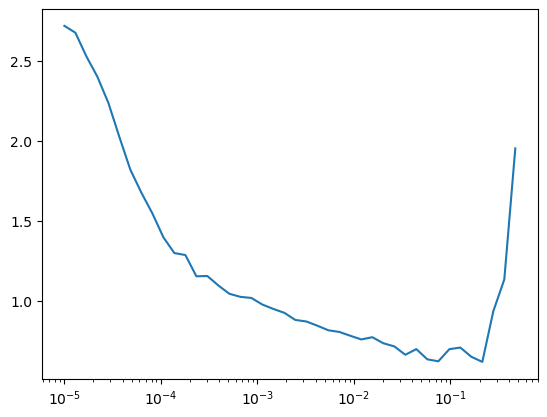

In [6]:
learn.lr_find()

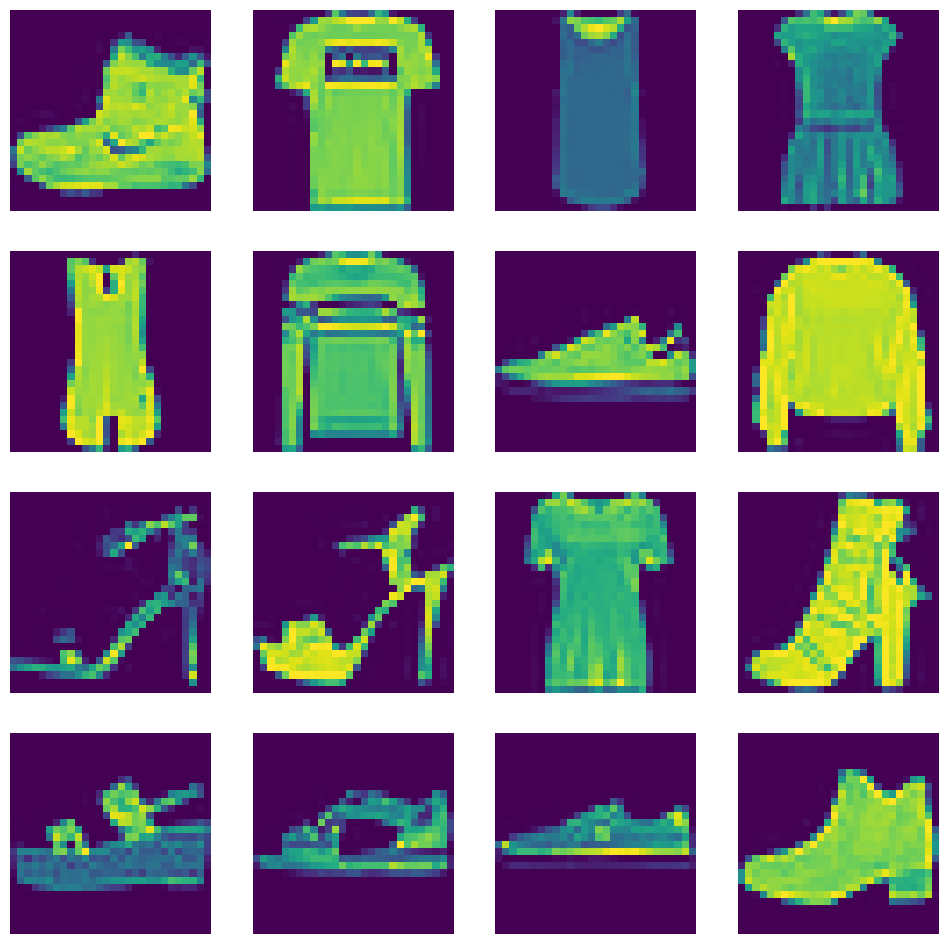

In [7]:
show_images(next(iter(dls.train))[0][:16])

In [8]:
from torchvision import transforms

tfms = nn.Sequential(
    transforms.RandomCrop(size=28, padding=2),
    transforms.RandomHorizontalFlip(),
    RandomErase(),
)


def im_tfms(b):
    xb, yb = b
    return tfms(xb), yb

tfmcb = BatchTransformCB(im_tfms, valid=False)

In [9]:
astats = ActivationStats()

epoch,train,loss,accuracy
0,train,0.7376,0.8124
0,eval,0.4064,0.8777
1,train,0.3906,0.8941
1,eval,0.3609,0.8852
2,train,0.2819,0.9152
2,eval,0.2822,0.9124
3,train,0.2095,0.9369
3,eval,0.2560,0.9205
4,train,0.1565,0.9566
4,eval,0.2331,0.9280


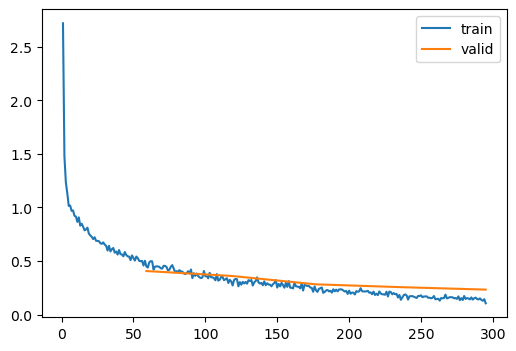

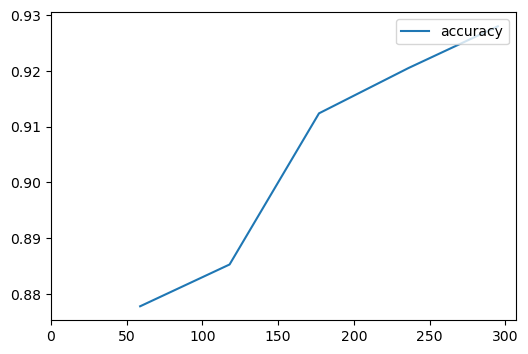

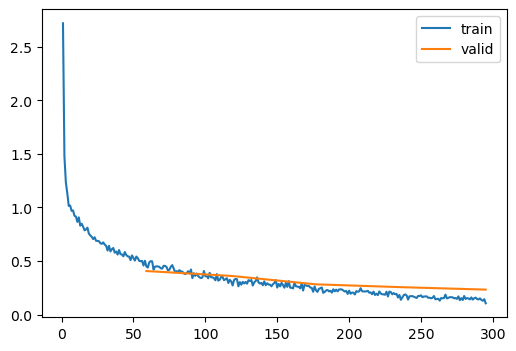

In [10]:
learn = get_learner()
learn.fit_one_cycle(5, lr=1e-2, metrics={"accuracy": MulticlassAccuracy()}, cbs=[PlotMetricsCB(), astats])

/Users/tom/fun/tinyai/tinyai/cbs.py:480: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tom/fun/tinyai/tinyai/cbs.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tom/fun/tinyai/tinyai/cbs.py:487: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


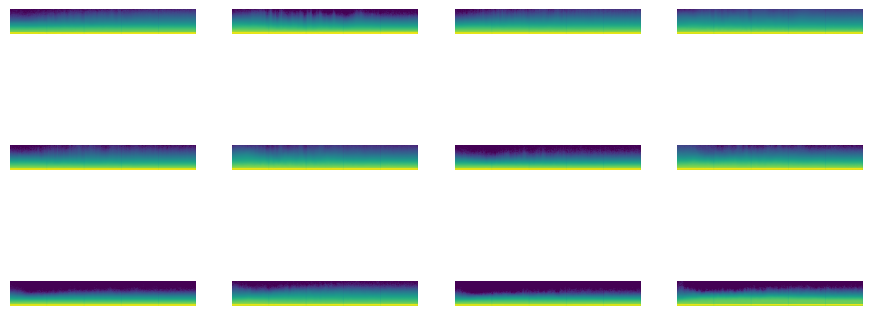

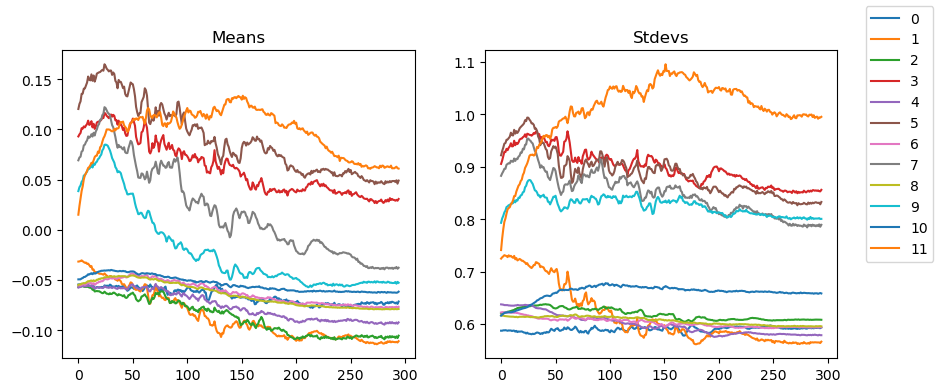

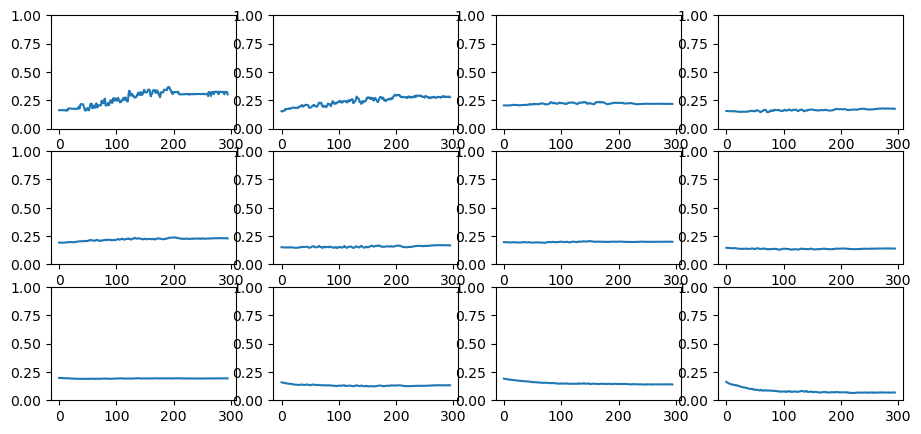

In [11]:
astats.plot_all()